# Regression

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 4 
plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline

Loading BokehJS ...

In [3]:
# Read configs:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm

In [4]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']

[03/09/23 14:35:13] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=432806;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=239657;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/09/23 14:35:14] INFO     Kedro project phd                                                      ]8;id=340961;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=614156;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=184588;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=112980;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=205578;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902025;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=859143;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=94154;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=877899;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=586579;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

In [5]:
ship_name

'M5064-02-A'

## Regression

In [6]:
meta_data = {
    's':shipdict.rudder_coeff_data['s'],
    #'nrud': len(shipdict.rudder_particulars),
    #'nprop':len(shipdict.rudder_particulars),
    #'xxprop':shipdict["fix_prop_data"][0]["xxfix"],
    #'tdf':shipdict["fix_prop_data"][0]["tdffix"],
    't': (shipdict.design_particulars["tf"] + shipdict.design_particulars["ta"]) / 2,
    'disp': shipdict.design_particulars["disp"],
    'lpp':  shipdict.main_data["l"],
    'rho':  df_VCT.iloc[0]["rho"],
    
    
}

In [7]:
lpp_ = shipdict.main_data['l']
t_ = shipdict.design_particulars['ta']
disp_ = shipdict.design_particulars['disp']
units={'fy_rudders':'force',
       'fy_rudder':'force',
       'tprop':'force',
      }
bis_system = BisSystem(lpp=lpp_, volume=disp_, units=units)

interesting = list((set(bis_system.qd.keys()) & set(df_VCT.columns)) |  (set(df_VCT.columns) & set(['test type', 'model_name','fy_rudders','fy_rudder','tprop'])))
interesting = list(set(interesting))
df_bis = bis_system.df_to_bis(df_VCT[interesting])

### $ktyh$

In [8]:
class Regression_ktyh(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (v_w.bis,0),
    (delta,0)
    ])

### $Y_{T\delta}$

In [9]:
class Regression_ytd(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (v_w.bis,0),
    (Y_uudelta, 0),
    ])
    intercept=True

### $Y_{uu\delta}$

In [10]:
class Regression_yuud(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (v_w.bis,0),
    ])

In [11]:
class Regression_yuv(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    (Y_uuv,0), # Note!
    ])
    
class Regression_yuv_nonlinear(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (phi.bis,0),
    (delta,0),
    (Y_vav,0), # Note!
    ])
    
class Regression_yur(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (v_w.bis,0),
    (phi.bis,0),
    (delta,0),
    (Y_uur,0), # Note!
    ])
    
class Regression_nuv(Regression):
    _eq = ss.equations.yaw.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (phi.bis,0),
    (delta,0),
    (N_uuv,0), # Note!
    ])
    
class Regression_nur(Regression):
    _eq = ss.equations.yaw.eq_expanded.subs([
    (phi.bis,0),
    (v_w.bis,0),
    (phi.bis,0),
    (delta,0),
    (N_uur,0), # Note!
    ])

In [12]:
class Regression_xxprop(Regression):
    _eq = ss.equations.yaw.eq_expanded.subs([
    (phi.bis,0),
    (v_w.bis,0),
    (r_w.bis,0),
    (delta,0),])

class Regression_xxrud(Regression):
    _eq = ss.equations.yaw.eq_expanded.subs([
    (phi.bis,0),
    (v_w.bis,0),
    (r_w.bis,0),
    ])
    


In [13]:
class Regression_xvv(Regression):
    _eq = ss.equations.surge.eq_expanded.subs([
    (phi.bis,0),
    #(n_prop, 0), # Note!
    #(n_rud, 0), # Note!    
    (delta,0),
    (r_w.bis,0),
    (X_res.bis,0)
    ])
    intercept=True

In [14]:
pre_set_derivatives_0 = {
    's':shipdict.rudder_coeff_data['s'],
    'kv':shipdict.rudder_coeff_data['kv'],
    'kr':shipdict.rudder_coeff_data['kr'],
}
pipeline = RegressionPipeline(shipdict=shipdict, pre_set_derivatives=pre_set_derivatives_0)

df_ = df_bis.groupby(by='test type').get_group('self propulsion')
pipeline['ktyh'] = Regression_ktyh(df=df_)
pipeline['xxprop'] = Regression_xxprop(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Thrust variation')
pipeline['ytd'] = Regression_ytd(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Rudder angle')
pipeline['yuud'] = Regression_yuud(df=df_)
pipeline['xxrud'] = Regression_xxrud(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Drift angle')

i=0
for V_,df__ in df_.groupby(by='V'):
    
    if len(df__) < 2:
        continue
        
    pipeline[f'yuv_{i}'] = Regression_yuv(df=df__, derivatives_suffix=f'_{i}')
    pipeline[f'nuv_{i}'] = Regression_nuv(df=df__, derivatives_suffix=f'_{i}')
    i+=1
    
df_ = df_bis.groupby(by='test type').get_group('Circle')
for i,(V_,df__) in enumerate(df_.groupby(by='V')):
    pipeline[f'yur_{i}'] = Regression_yur(df=df__, derivatives_suffix=f'_{i}')
    pipeline[f'nur_{i}'] = Regression_nur(df=df__, derivatives_suffix=f'_{i}')

In [15]:
pipeline.keys()

odict_keys(['ktyh', 'xxprop', 'ytd', 'yuud', 'xxrud', 'yuv_0', 'nuv_0', 'yuv_1', 'nuv_1', 'yur_0', 'nur_0', 'yur_1', 'nur_1'])

In [16]:
regression = pipeline['yuv_0']
regression.eq

Eq(Y, T_prop*ktyh*n_prop + Y_uudelta*k_v*n_rud*u_w*v_w*(k_v**2*s*v_w**2/u_w**2 + 1) + Y_uv*u_w*v_w + Y_{v|v|}*v_w*Abs(v_w))

In [17]:
pipeline.fit()
pipeline.derivatives

{'s': -1.651328353043133,
 'kv': -0.5,
 'kr': 0.5,
 'ktyh': -0.0018559232308727413,
 'xxprop': -0.5157889171934192,
 'ytd': 0.9441573216960572,
 'const': 0.00862641738521433,
 'yuud': 0.30557947274827846,
 'xxrud': -0.49111969741173156,
 'yuv_0': -0.16287406159401918,
 'yvav_0': -5.114990118531723,
 'nuv_0': -0.3233911842305083,
 'nvav_0': -0.6896553614138607,
 'yuv_1': -0.46287553951362204,
 'yvav_1': -3.888413552986232,
 'nuv_1': -0.3665928212769282,
 'nvav_1': -0.5235480871012762,
 'yur_0': 0.25308450823221174,
 'nrar_0': -0.21238174310105412,
 'nur_0': -0.09861941539153013,
 'yur_1': 0.2430846322241797,
 'nrar_1': -0.28276375070038795,
 'nur_1': -0.09022150702900374,
 'yuuv': -4.561170834181079,
 'yuv': 0.6371298795249237,
 'yuur': -0.15203639365232105,
 'yur': 0.27975084425363056,
 'nuuv': -0.6568302538089985,
 'nuv': -0.20818681877338818,
 'nuur': 0.12768035329994573,
 'nur': -0.12101383769160057,
 'yvav': -3.8889416332472124,
 'nvav': -0.6557684049404803,
 'nrar': -0.21987596668

In [24]:
pre_set_derivatives_2 = pre_set_derivatives_0.copy()
pre_set_derivatives_2.update({
    'yvav':pipeline.derivatives['yvav'],
    'nvav':pipeline.derivatives['nvav'],
    'nrar':pipeline.derivatives['nrar'],
    #'tdf': shipdict['fix_prop_data'][0]['tdffix'],
})

pipeline2 = RegressionPipeline(shipdict=shipdict, pre_set_derivatives=pre_set_derivatives_2)

df_ = df_bis.groupby(by='test type').get_group('self propulsion')
pipeline2['ktyh'] = Regression_ktyh(df=df_)
pipeline2['xxprop'] = Regression_xxprop(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Thrust variation')
pipeline2['ytd'] = Regression_ytd(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Rudder angle')
pipeline2['yuud'] = Regression_yuud(df=df_)
pipeline2['xxrud'] = Regression_xxrud(df=df_)

df_ = df_bis.groupby(by='test type').get_group('Drift angle')
i=0
for V_,df__ in df_.groupby(by='V'):
    
    if len(df__) < 2:
        continue    
    
    pipeline2[f'yuv_{i}'] = Regression_yuv(df=df__, derivatives_suffix=f'_{i}')
    pipeline2[f'nuv_{i}'] = Regression_nuv(df=df__, derivatives_suffix=f'_{i}')
    pipeline2[f'xvv_{i}'] = Regression_xvv(df=df__, derivatives_suffix=f'_{i}')
    i+=1
df_ = df_bis.groupby(by='test type').get_group('Circle')
for i,(V_,df__) in enumerate(df_.groupby(by='V')):
    pipeline2[f'yur_{i}'] = Regression_yur(df=df__, derivatives_suffix=f'_{i}')
    pipeline2[f'nur_{i}'] = Regression_nur(df=df__, derivatives_suffix=f'_{i}')

Loading BokehJS ...

In [25]:
pipeline2.fit()
pipeline2.derivatives

{'s': -1.651328353043133,
 'kv': -0.5,
 'kr': 0.5,
 'yvav': -3.8889416332472124,
 'nvav': -0.6557684049404803,
 'nrar': -0.21987596668258358,
 'ktyh': -0.0018559232308727413,
 'xxprop': -0.5157889171934192,
 'ytd': 0.9441573216960572,
 'const': 0.004127343771962314,
 'yuud': 0.30557947274827846,
 'xxrud': -0.49111969741173156,
 'yuv_0': -0.7037920013359351,
 'nuv_0': -0.3383417044584677,
 'xvv_0': 0.07409905320587545,
 'const_0': 0.003391969677858721,
 'yuv_1': -0.46275552846534707,
 'nuv_1': -0.3365445499827274,
 'xvv_1': -0.1669002867528259,
 'const_1': 0.005607519836388225,
 'yur_0': 0.25308450823221174,
 'nur_0': -0.09551967047518621,
 'yur_1': 0.2430846322241797,
 'nur_1': -0.10281382180065342,
 'yuuv': 3.6646770464438663,
 'yuv': -1.346555928990838,
 'yuur': -0.15203639365232105,
 'yur': 0.27975084425363056,
 'nuuv': 0.027323627323799875,
 'nuv': -0.343134116393775,
 'nuur': -0.11089902128662261,
 'nur': -0.07606860027394027,
 'xvv': 0.03897307694858479,
 'cd': 0.6992344101564226

In [26]:
pipeline2.stds

{'ktyh': 0.0004701355151988335,
 'xxprop': 0.11146743740785735,
 'ytd': 0.027810339140150346,
 'const': 0.0001562657470737262,
 'yuud': 0.010963414742204972,
 'xxrud': 0.011601730674100322,
 'yuv_0': 0.0929229154908819,
 'nuv_0': 0.024171820444303545,
 'xvv_0': 0.04517736640979674,
 'const_0': 0.00019118239477617854,
 'yuv_1': 0.00043302709670664264,
 'nuv_1': 0.017457774721470868,
 'xvv_1': 0.10937215992785909,
 'const_1': 0.00027123793083944905,
 'yur_0': 0.007687406533006315,
 'nur_0': 0.0014706679013672494,
 'yur_1': 0.01384558161882245,
 'nur_1': 0.0026373187871218703,
 'yuuv': 0.36232976744922607,
 'yuv': 0.17793524154994647,
 'yuur': 0.06175001645241604,
 'yur': 0.026979371466292458,
 'nuuv': 0.11626252778878503,
 'nuv': 0.054360638717467845,
 'nuur': 0.011774263612874626,
 'nur': 0.005145713682813409,
 'xvv': 0.0417554399552615}

In [27]:
regression = pipeline2['xvv_1']
regression.eq

Eq(X, -T_prop*n_prop*tdf + T_prop*n_prop + X_vv*v_w**2)

In [28]:
regression.eq_excluded

Eq(T_prop*n_prop*tdf - T_prop*n_prop + X, X_vv*v_w**2)

In [29]:
pipeline2['xvv_1'].summary()

[03/09/23 14:43:06] WARNING  /home/maa/dev/PHD/venv/lib/python3.10/site-packages/statsmodels/stats/ ]8;id=255963;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=880727;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             stattools.py:74: ValueWarning: omni_normtest is not valid with less                   
                             than 8 observations; 3 samples were given.                                            
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     -fx - nprop*tdf*tprop + nprop*tprop   R-squared (uncentered):                   0.999
Model:                                             OLS   Adj. R-squared (uncentered):              0.998
Method:                                  Least Squares   F-statistic:                              730.3
Date:                                 Thu, 09 Mar 2023   Prob (F-statistic):                      0.0262
Time:                                         14:43:06   Log-Likelihood:                          22.046
No. Observations:                                    3   AIC:                                     -40.09
Df Residuals:                                        1   BIC:                                     -41.89
Df Model:                                            2                                                  
Covariance Type:                             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xvv           -0.1669      0.109     -1.526      0.369      -1.557       1.223
const          0.0056      0.000     20.674      0.031       0.002       0.009
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.962
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.491
Skew:                          -0.647   Prob(JB):                        0.782
Kurtosis:                       1.500   Cond. No.                         702.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

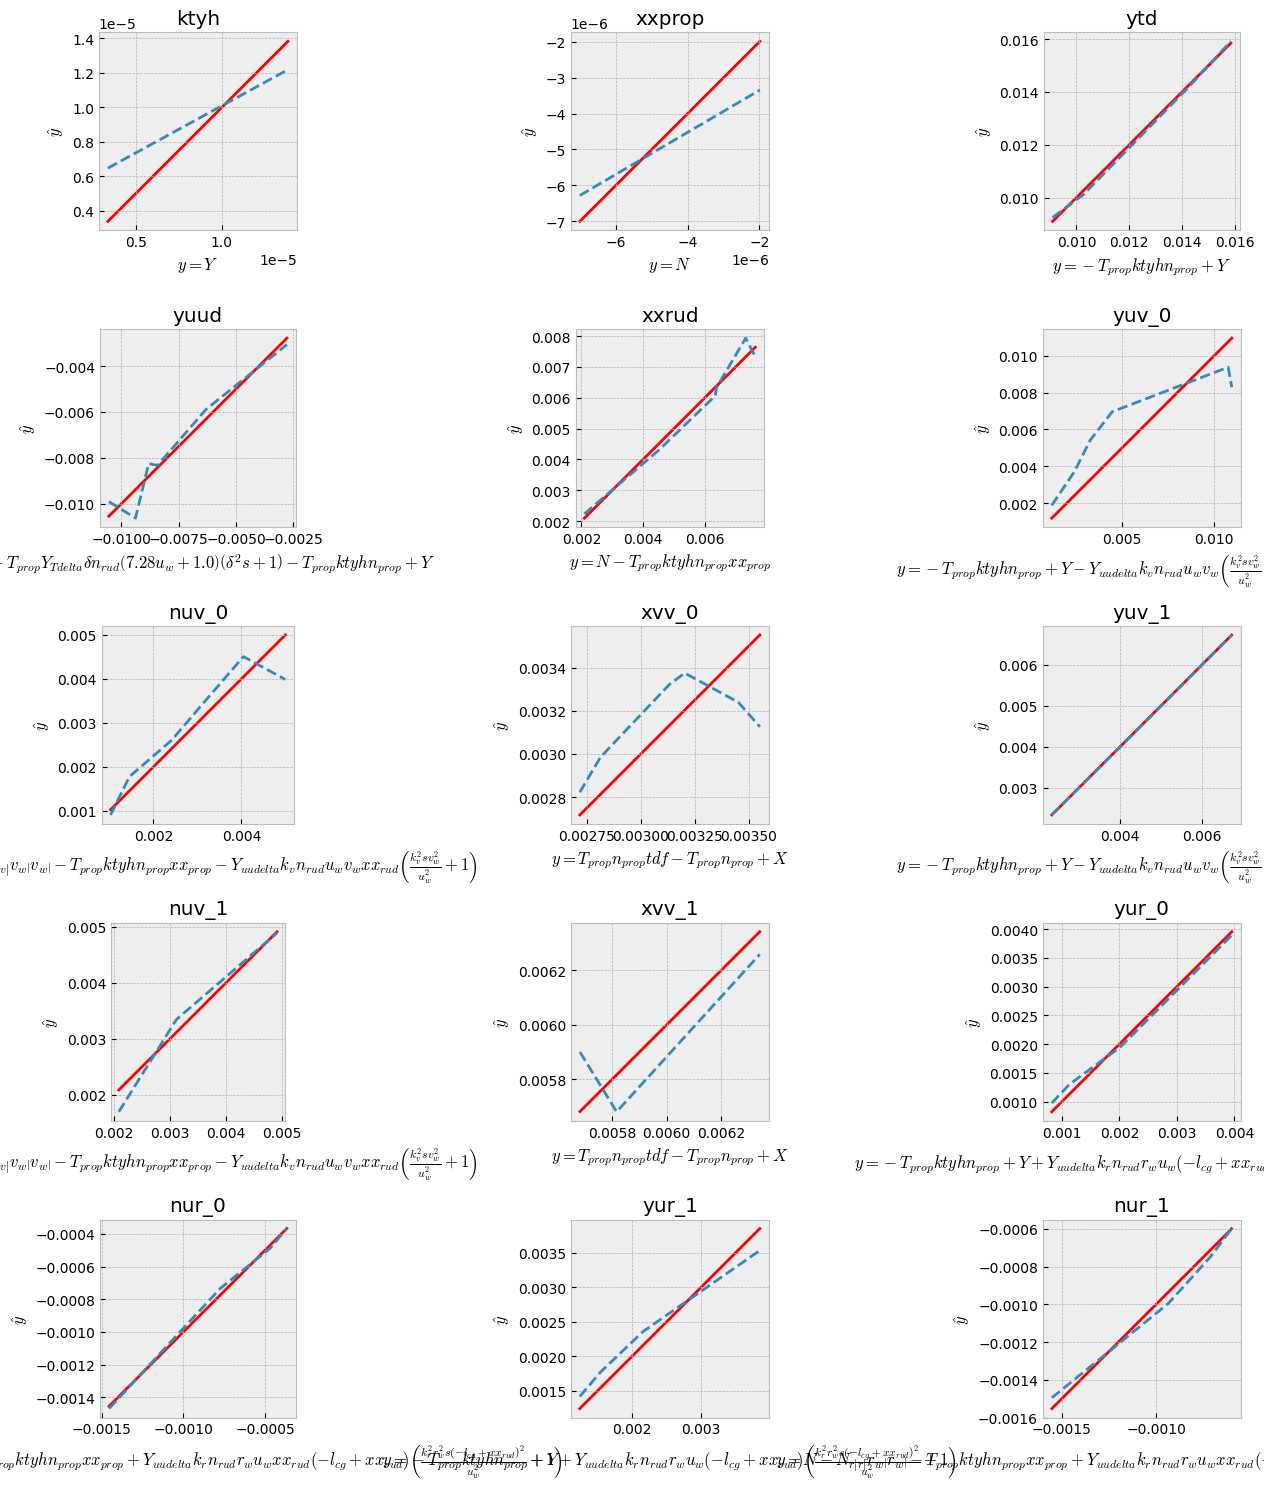

In [30]:
pipeline2.plot_fit();

In [31]:
new_shipdict = pipeline2.create_shipdict()

In [32]:
assert new_shipdict.non_lin_coeff_data['cdlever'] == pipeline.derivatives['cdlever']

In [33]:
def assemble_derivatives(shipdict, name:str):
    s = pd.Series({
    
        'cd' : shipdict.non_lin_coeff_data['cd'],
        'cdlever' : shipdict.non_lin_coeff_data.get('cdlever',0),
        'kr' : shipdict.rudder_coeff_data['kr'],
        'kv' : shipdict.rudder_coeff_data['kv'],
        'kuv': shipdict.lin_hull_coeff_data['kuv'],
        'nur': shipdict.lin_hull_coeff_data['nur'],
        'nuur': shipdict.lin_hull_coeff_data['nuur'],
        'nuv': shipdict.lin_hull_coeff_data['nuv'],
        'nuuv': shipdict.lin_hull_coeff_data['nuuv'],
        'nuuf': shipdict.lin_hull_coeff_data['nuuf'],
        'yuv': shipdict.lin_hull_coeff_data['yuv'],
        'yuuv': shipdict.lin_hull_coeff_data['yuuv'],
        'yur': shipdict.lin_hull_coeff_data['yur'],
        'yuur': shipdict.lin_hull_coeff_data['yuur'],    
        'xrr': shipdict.resistance_data['xrr'],
        'xvr': shipdict.resistance_data['xvr'],
        'xvv': shipdict.resistance_data['xvv'],
        'yuud': shipdict.rudder_coeff_data['yuud'],
        'ytd': shipdict.rudder_coeff_data['ytd'],
        's': shipdict.rudder_coeff_data['s'],
        'xyrd': shipdict.rudder_coeff_data['xyrd'],
        'xxrud' : shipdict.rudder_particulars[0]['xxrud'],
        
    }, name=name)
    return s

In [34]:
df_coefficients = pd.DataFrame([
    assemble_derivatives(shipdict=shipdict,name='base'),
    assemble_derivatives(shipdict=new_shipdict,name='regression'),
    
])

In [35]:
df_coefficients

,cd,cdlever,kr,kv,kuv,nur,nuur,nuv,nuuv,nuuf,yuv,yuuv,yur,yuur,xrr,xvr,xvv,yuud,ytd,s,xyrd,xxrud
base,0.756830,0.000000,0.5,-0.5,0.056767,-0.176446,0.151449,-0.951457,2.253122,0.0,-1.033345,2.341734,0.314860,-0.133702,0.0,-0.690256,0.112281,0.285999,1.163502,-1.651328,-0.631645,-112.250000
regression,0.699234,0.168624,0.5,-0.5,0.056767,-0.076069,-0.110899,-0.343134,0.027324,0.0,-1.346556,3.664677,0.279751,-0.152036,0.0,-0.690256,0.038973,0.305579,0.944157,-1.651328,-0.631645,-110.256372


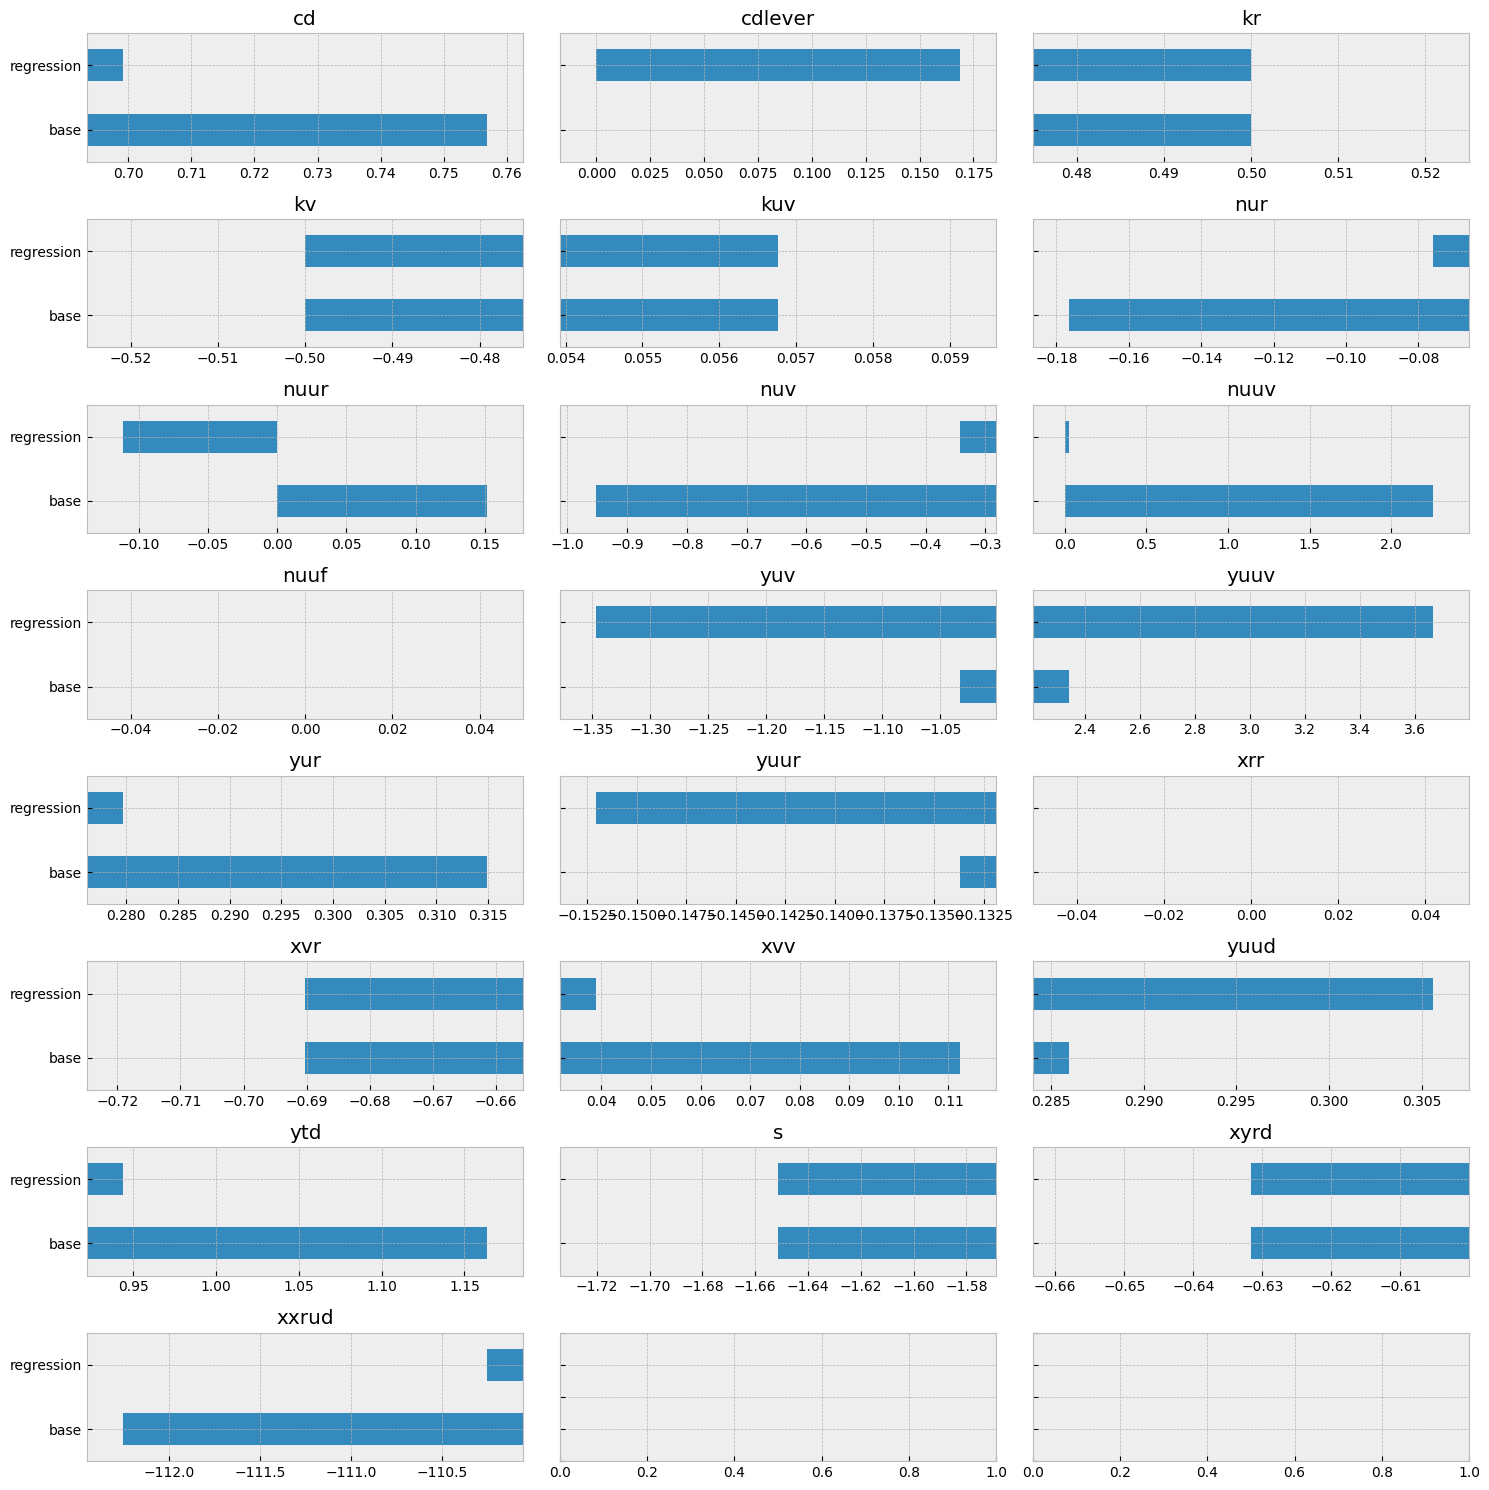

In [36]:
ncols = 3
nrows = int(np.ceil(len(df_coefficients.columns)/ncols))
fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)
for ax, key in zip(axes.flatten(), df_coefficients):
    
    df_coefficients[key].plot.barh(ax=ax)
    ax.set_title(key)
    
    amplitude = df_coefficients[key].max() - df_coefficients[key].min()
    ax.set_xlim(df_coefficients[key].min()-0.1*amplitude, df_coefficients[key].max()+0.1*amplitude)
    ax.grid(True)
    
for ax in axes[:,1:].flatten():
    ax.set_yticklabels([])
    
plt.tight_layout()

In [37]:
results_sym_seaman = calculate_ship(shipdict=new_shipdict, df=df_VCT)

In [38]:
import symseaman.calculate
symseaman.calculate.lambda_surge

<function _lambdifygenerated(delta, disp, g, l, nprop, nrud, r, rho, tdf, tprop, u, v, xres, xrr, xvr, xvv, xyrd, ytd, yuud)>

In [39]:
nrud_ = len(shipdict.rudder_particulars)
nprop_ = len(shipdict.rudder_particulars)
ktyh_ = shipdict["propeller_coeff_data"][1]["ktyh"]
xxprop_ = shipdict["fix_prop_data"][0]["xxfix"]
tdf_ = shipdict["fix_prop_data"][0]["tdffix"]
    
run(
        function=symseaman.calculate.lambda_surge,
        inputs=results_sym_seaman,
        **shipdict.main_data,
        **shipdict.design_particulars,
        **shipdict.rudder_coeff_data,
        # **shipdict.rudder_particulars[0],
        **shipdict.resistance_data,
        nrud=nrud_,
        nprop=nprop_,
        tdf=tdf_,
    )

0     1.138174e+05
1     7.045490e+04
2     8.778728e+04
3     5.887080e+04
4     1.372568e+05
5     1.752576e+05
6     1.266507e+05
7     8.173465e+04
8     1.618258e+06
9     2.578598e+06
10    1.858765e+05
11    4.984767e+05
12    1.470916e+05
13    2.612695e+05
14    3.754863e+05
15    8.320930e+04
16    6.132579e+04
17    2.327737e+05
18    5.139559e+05
19    6.318610e+05
20    1.074760e+06
21    1.733286e+05
22    1.502708e+05
23    5.047009e+05
24   -1.094341e+05
25   -3.390327e+05
26   -7.307017e+05
27   -1.293318e+06
28   -2.025927e+06
29   -4.057983e+06
30   -2.020970e+06
31   -1.695824e+06
32   -1.944498e+05
33    4.499495e+05
34   -2.527614e+04
35   -3.775644e+04
dtype: float64

In [40]:
results = pd.concat((results_sym_seaman, df_VCT), axis=0, ignore_index=True)

In [41]:
#ys = ['fx','fy','mz','fx_hull','fy_hull','mz_hull','fx_rudder','fy_rudder','mz_rudder']
ys = ['fx','fy','mz']
  
tabs = bokeh_plotting.create_tab(df_VCT = results, ys=ys, plot_height=300)